In [81]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import scipy as scipy
from scipy import linalg
import matplotlib.pyplot as plt

In [82]:
# Define the state-space model
dt = 0.1  # Time step
omega = 1.0  # Natural frequency
A_euler = np.array([[0, dt], [-omega**2 * dt, 0]])  # State transition matrix using forward Euler
A = scipy.linalg.expm(A_euler)
H = np.array([[1, 0]])  # Measurement matrix
Q = np.eye(2) * 0.005 * dt  # Process noise covariance
R = np.eye(1) * 0.5  # Measurement noise covariance

# Initialize state estimate and covariance
x_est = np.array([[1], [0]])  # Initial position and velocity
P = np.eye(2) * 1.0  # Initial uncertainty

# Simulate noisy measurements
periods = 6
time_steps = round(periods*2*np.pi/dt)
true_states = []
measurements = []
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())

In [83]:
#helper functions
# euclidean norm
def s(m):
    return np.sqrt(np.sum(m**2))

#c is normal with mean 0 and variance s(m) x sigma_y^2

def measure(x, m, sigma_y):
    
    c = np.random.normal(0, s(m) * sigma_y^2)  
    measurement_y = m.T @ x + c
    return measurement_y

def compute_eigenvector(A):
    # Compute the eigen decomposition of the matrix A
    eigvals, eigvecs = np.linalg.eig(A)
    # Find the index of the largest eigenvalue
    idx = np.argmax(eigvals)
    # Return the largest eigenvalue and the corresponding unit eigenvector
    return eigvals[idx], eigvecs[:,idx]


#find principal component of the covariance matrix
def select_measurement_direction(P):
    # Compute the largest eigenvector of the covariance matrix
    eigenvalue, eigenvector = compute_eigenvector(P)
    return eigenvector




In [84]:
# Implement the Kalman Filter
filtered_states = []
for z in measurements:
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q
    
    # Compute Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    
    # Update Step
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(2) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

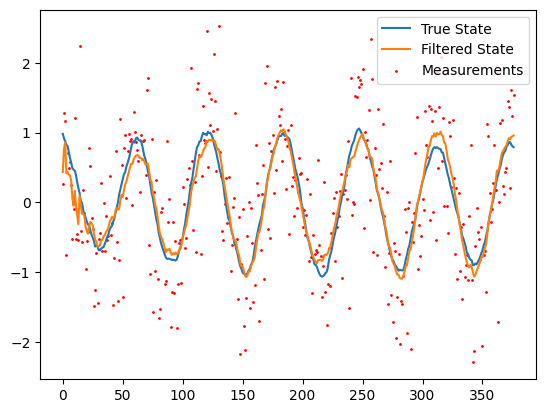

In [85]:
# Plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in filtered_states], label='Filtered State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
plt.legend()
plt.show()

In [86]:


def kalman_update(x, P, y, sigma2):
    # Select optimal measurement direction based on current uncertainty
    m = select_measurement_direction(P)
    
    # Compute innovation: difference between observed measurement and predicted measurement
    innovation = y - np.dot(m.T, x)
    
    # innovation variance
    S = np.dot(m.T, np.dot(P, m)) + sigma2
    
    # Kalman Gain.
    K = np.dot(P, m) / S
    
    # updating state estimate
    x_new = x + K * innovation
    
    # Update covariance matrix
    P_new = P - np.outer(K, np.dot(m.T, P))
    
    return x_new, P_new, m



States2 = []

### iterative process
def iterate_kalman(x, P, y, sigma2, time_steps):
    for i in range(time_steps):
        x, P, m = kalman_update(x, P, y, sigma2)
        print(x)
        States2.append(x)
    return x, P, m

x = np.array([[1], [0]])
P = np.array([[1, 0], [0, 1]])
sigma2 = 0.1

y = 1
x_new, P_new, m = iterate_kalman(x, P, y, sigma2, time_steps)

print(x_new)
print(P_new)
print(m)







[[1. 1.]
 [0. 0.]]
[[1.         1.90909091]
 [0.         0.90909091]]
[[1.         1.90909091]
 [0.         0.90909091]]
[[1.         1.95238095]
 [0.         0.95238095]]
[[1.         1.95238095]
 [0.         0.95238095]]
[[1.         1.96774194]
 [0.         0.96774194]]
[[1.         1.96774194]
 [0.         0.96774194]]
[[1.         1.97560976]
 [0.         0.97560976]]
[[1.         1.97560976]
 [0.         0.97560976]]
[[1.         1.98039216]
 [0.         0.98039216]]
[[1.         1.98039216]
 [0.         0.98039216]]
[[1.         1.98360656]
 [0.         0.98360656]]
[[1.         1.98360656]
 [0.         0.98360656]]
[[1.         1.98591549]
 [0.         0.98591549]]
[[1.         1.98591549]
 [0.         0.98591549]]
[[1.         1.98765432]
 [0.         0.98765432]]
[[1.         1.98765432]
 [0.         0.98765432]]
[[1.         1.98901099]
 [0.         0.98901099]]
[[1.         1.98901099]
 [0.         0.98901099]]
[[1.         1.99009901]
 [0.         0.99009901]]
[[1.        

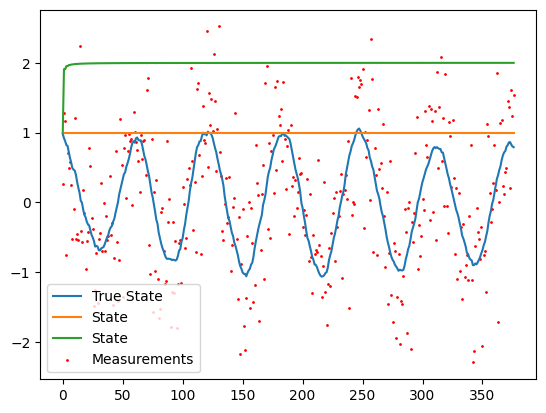

In [87]:
# plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in States2], label='State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
plt.legend()
plt.show()